In [2]:
!pip install bambi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 2.7 MB/s eta 0:00:00


In [4]:
#!/usr/bin/env python
"""
Bayesian Regression Analyses for Eye-Tracking Reading Measures
==============================================================

This script replicates the psycholinguistic analyses from the EMTeC paper.
It fits Bayesian mixed-effects regression models to predict reading measures
from lexical predictors (word length, lexical frequency, surprisal).

The analyses follow the methodology in baseline_analyses.R, using:
- Lognormal models for continuous reading time measures
- Bernoulli (logistic) models for binary fixation measures
- Poisson models for count measures

Usage:
    python baseline_analyses.py --response FPRT --iterations 6000
    python baseline_analyses.py -r TFT -i 6000
"""

import argparse
import warnings
from pathlib import Path

import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd
from scipy import stats

warnings.filterwarnings("ignore")

# Define variable types for model selection
LOG_LINEAR_VARIABLES = ["FFD", "SFD", "FD", "FPRT", "FRT", "TFT", "RRT"]
BINARY_VARIABLES = ["Fix", "FPF", "RR", "FPReg"]
COUNT_VARIABLES = ["TFC"]

# Model parameters
WARMUP_ITERATIONS = 2000
DEFAULT_ITERATIONS = 6000
N_CHAINS = 4
RANDOM_SEED = 42


def load_and_preprocess_data(filepath: str) -> pd.DataFrame:
    """
    Load and preprocess the reading measures data.

    Preprocessing steps:
    - Convert subject_id to categorical
    - Scale predictors (z-score standardization)
    - Create log lexical frequency from Zipf frequency

    Parameters
    ----------
    filepath : str
        Path to the reading measures CSV file

    Returns
    -------
    pd.DataFrame
        Preprocessed dataframe ready for modeling
    """
    print(f"Loading data from {filepath}...")
    df = pd.read_csv(filepath, sep="\t")

    print(f"  Loaded {len(df):,} observations")
    print(f"  Number of subjects: {df['subject_id'].nunique()}")
    print(f"  Number of items: {df['item_id'].nunique()}")

    # Convert subject_id to categorical
    df["subject_id"] = df["subject_id"].astype("category")

    # Scale predictors (z-score standardization)
    # This matches the R code: scale(df$zipf_freq), scale(df$word_length_with_punct), etc.
    df["log_lex_freq"] = stats.zscore(df["zipf_freq"])
    df["word_length"] = stats.zscore(df["word_length_with_punct"])
    df["surprisal"] = stats.zscore(df["surprisal_gpt2"])

    # Ensure last_in_line is numeric (0/1)
    df["last_in_line"] = df["last_in_line"].astype(int)

    print("  Preprocessing complete.")
    return df


def get_model_formula(response_var: str) -> str:
    """
    Construct the model formula.

    The formula includes:
    - Random intercept for subject_id
    - Fixed effects: word_length, log_lex_freq, surprisal, last_in_line

    Parameters
    ----------
    response_var : str
        The response variable name

    Returns
    -------
    str
        Bambi formula string
    """
    return f"{response_var} ~ (1 | subject_id) + word_length + log_lex_freq + surprisal + last_in_line"


def run_lognormal_model(
    formula: str, data: pd.DataFrame, iterations: int = DEFAULT_ITERATIONS
) -> bmb.Model:
    """
    Fit a Gaussian regression model on log-transformed reading time measures.

    This is appropriate for positively-skewed reaction time data.
    We log-transform the response and fit a Gaussian model: log(y) ~ Normal(μ, σ)
    This is equivalent to a lognormal model.

    Priors (matching R code):
    - Intercept: Normal(6, 1.5)
    - Fixed effects: Normal(0, 1)
    - Sigma: HalfNormal(1)

    Parameters
    ----------
    formula : str
        Model formula
    data : pd.DataFrame
        Data for fitting
    iterations : int
        Number of MCMC iterations

    Returns
    -------
    bmb.Model
        Fitted Bambi model
    """
    print("\nFitting lognormal model (via log-transformed Gaussian)...")

    # Extract response variable name from formula
    response_var = formula.split("~")[0].strip()

    # Log-transform the response variable
    data = data.copy()
    data[response_var] = np.log(data[response_var])

    # Define priors matching the R code
    priors = {
        "Intercept": bmb.Prior("Normal", mu=6, sigma=1.5),
        "word_length": bmb.Prior("Normal", mu=0, sigma=1),
        "log_lex_freq": bmb.Prior("Normal", mu=0, sigma=1),
        "surprisal": bmb.Prior("Normal", mu=0, sigma=1),
        "last_in_line": bmb.Prior("Normal", mu=0, sigma=1),
        "sigma": bmb.Prior("HalfNormal", sigma=1),
    }

    # Build and fit model using Gaussian family on log-transformed data
    model = bmb.Model(formula, data, family="gaussian", priors=priors)

    results = model.fit(
        draws=max(iterations - WARMUP_ITERATIONS, 1000),
        tune=min(WARMUP_ITERATIONS, iterations // 2),
        chains=N_CHAINS,
        random_seed=RANDOM_SEED,
        progressbar=True,
    )

    return model, results


def run_bernoulli_model(
    formula: str, data: pd.DataFrame, iterations: int = DEFAULT_ITERATIONS
) -> bmb.Model:
    """
    Fit a Bernoulli (logistic) regression model for binary measures.

    This is appropriate for binary outcomes like fixation (yes/no).
    Uses logit link function: logit(p) = Xβ

    Priors (matching R code):
    - Intercept: Normal(0, 4)
    - Fixed effects: Normal(0, 1)

    Parameters
    ----------
    formula : str
        Model formula
    data : pd.DataFrame
        Data for fitting
    iterations : int
        Number of MCMC iterations

    Returns
    -------
    bmb.Model
        Fitted Bambi model
    """
    print("\nFitting Bernoulli (logistic) model...")

    # Define priors matching the R code
    priors = {
        "Intercept": bmb.Prior("Normal", mu=0, sigma=4),
        "word_length": bmb.Prior("Normal", mu=0, sigma=1),
        "log_lex_freq": bmb.Prior("Normal", mu=0, sigma=1),
        "surprisal": bmb.Prior("Normal", mu=0, sigma=1),
        "last_in_line": bmb.Prior("Normal", mu=0, sigma=1),
    }

    model = bmb.Model(formula, data, family="bernoulli", priors=priors)

    results = model.fit(
        draws=max(iterations - WARMUP_ITERATIONS, 1000),
        tune=min(WARMUP_ITERATIONS, iterations // 2),
        chains=N_CHAINS,
        random_seed=RANDOM_SEED,
        progressbar=True,
    )

    return model, results


def run_poisson_model(
    formula: str, data: pd.DataFrame, iterations: int = DEFAULT_ITERATIONS
) -> bmb.Model:
    """
    Fit a Poisson regression model for count measures.

    This is appropriate for count data like total fixation count (TFC).
    Uses log link function: log(λ) = Xβ

    Parameters
    ----------
    formula : str
        Model formula
    data : pd.DataFrame
        Data for fitting
    iterations : int
        Number of MCMC iterations

    Returns
    -------
    bmb.Model
        Fitted Bambi model
    """
    print("\nFitting Poisson model...")

    model = bmb.Model(formula, data, family="poisson")

    results = model.fit(
        draws=max(iterations - WARMUP_ITERATIONS, 1000),
        tune=min(WARMUP_ITERATIONS, iterations // 2),
        chains=N_CHAINS,
        random_seed=RANDOM_SEED,
        progressbar=True,
    )

    return model, results


def print_model_summary(results, response_var: str):
    """
    Print a summary of the fitted model results.

    Parameters
    ----------
    results : InferenceData
        ArviZ InferenceData object with posterior samples
    response_var : str
        Name of the response variable
    """
    print(f"\n{'='*60}")
    print(f"Model Summary for {response_var}")
    print("=" * 60)

    # Print ArviZ summary
    summary = az.summary(
        results,
        var_names=[
            "Intercept",
            "word_length",
            "log_lex_freq",
            "surprisal",
            "last_in_line",
        ],
        hdi_prob=0.95,
    )
    print(summary)

    # Print convergence diagnostics
    print(f"\n{'='*60}")
    print("Convergence Diagnostics")
    print("=" * 60)

    # R-hat values
    rhat = az.rhat(results)
    print("\nR-hat values (should be close to 1.0):")
    for var in [
        "Intercept",
        "word_length",
        "log_lex_freq",
        "surprisal",
        "last_in_line",
    ]:
        if var in rhat:
            print(f"  {var}: {float(rhat[var].values):.4f}")

    # Effective sample size
    ess = az.ess(results)
    print("\nEffective Sample Size:")
    for var in [
        "Intercept",
        "word_length",
        "log_lex_freq",
        "surprisal",
        "last_in_line",
    ]:
        if var in ess:
            print(f"  {var}: {float(ess[var].values):.0f}")


def save_results(model, results, response_var: str, output_dir: str = "model_fits"):
    """
    Save model results to disk.

    Parameters
    ----------
    model : bmb.Model
        The fitted Bambi model
    results : InferenceData
        ArviZ InferenceData object
    response_var : str
        Name of the response variable
    output_dir : str
        Directory for saving results
    """
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    # Save the InferenceData (posterior samples)
    netcdf_path = output_path / f"baseline_{response_var}.nc"
    results.to_netcdf(str(netcdf_path))
    print(f"\nResults saved to {netcdf_path}")

    # Save summary as CSV
    summary = az.summary(results, hdi_prob=0.95)
    csv_path = output_path / f"baseline_{response_var}_summary.csv"
    summary.to_csv(csv_path)
    print(f"Summary saved to {csv_path}")


def main():
    """Main function to run the analysis."""
    parser = argparse.ArgumentParser(
        description="Fit Bayesian regression models for reading measures."
    )
    parser.add_argument(
        "-r",
        "--response",
        type=str,
        default="FPRT",
        help="Response variable to model (e.g., FPRT, TFT, Fix, FPReg, TFC)",
    )
    parser.add_argument(
        "-i",
        "--iterations",
        type=int,
        default=DEFAULT_ITERATIONS,
        help=f"Number of MCMC iterations (default: {DEFAULT_ITERATIONS})",
    )
    parser.add_argument(
        "--data-path",
        type=str,
        default="/kaggle/input/emtec-ds/reading_measures_corrected.csv",
        help="Path to the reading measures data file",
    )
    parser.add_argument(
        "--output-dir",
        type=str,
        default="model_fits",
        help="Directory for saving model results",
    )
    parser.add_argument(
        "--sample-frac",
        type=float,
        default=1.0,
        help="Fraction of data to use (0.0-1.0). Use smaller values for faster testing.",
    )
    parser.add_argument(
        "--n-subjects",
        type=int,
        default=10,
        help="Number of subjects to include. Use smaller values for faster testing.",
    )
    args, _ = parser.parse_known_args()
    response_var = args.response
    iterations = args.iterations

    print("=" * 60)
    print("EMTeC Baseline Psycholinguistic Analysis")
    print("=" * 60)
    print(f"\nResponse variable: {response_var}")
    print(f"Iterations: {iterations}")
    print(f"Warmup: {WARMUP_ITERATIONS}")
    print(f"Chains: {N_CHAINS}")

    # Validate response variable
    all_valid = LOG_LINEAR_VARIABLES + BINARY_VARIABLES + COUNT_VARIABLES
    if response_var not in all_valid:
        raise ValueError(
            f"Invalid response variable: {response_var}. " f"Valid options: {all_valid}"
        )

    # Load and preprocess data
    data = load_and_preprocess_data(args.data_path)

    # Optionally subsample data for faster testing
    if args.n_subjects is not None:
        subjects = data["subject_id"].unique()[: args.n_subjects]
        data = data[data["subject_id"].isin(subjects)].copy()
        print(f"\nSubsampled to {args.n_subjects} subjects: {len(data):,} observations")

    if args.sample_frac < 1.0:
        data = data.sample(frac=args.sample_frac, random_state=RANDOM_SEED).copy()
        print(
            f"\nSubsampled to {args.sample_frac*100:.1f}% of data: {len(data):,} observations"
        )

    # Get the model formula
    formula = get_model_formula(response_var)
    print(f"\nModel formula: {formula}")

    # Select appropriate model type and fit
    if response_var in LOG_LINEAR_VARIABLES:
        # For lognormal models, remove zero values
        data_subset = data[data[response_var] > 0].copy()
        print(f"\nFiltered to {len(data_subset):,} non-zero observations")
        model, results = run_lognormal_model(formula, data_subset, iterations)

    elif response_var in BINARY_VARIABLES:
        model, results = run_bernoulli_model(formula, data, iterations)

    elif response_var in COUNT_VARIABLES:
        model, results = run_poisson_model(formula, data, iterations)

    # Print and save results
    print_model_summary(results, response_var)
    save_results(model, results, response_var, args.output_dir)

    print("\n" + "=" * 60)
    print("Analysis complete!")
    print("=" * 60)

    return model, results


if __name__ == "__main__":
    main()


EMTeC Baseline Psycholinguistic Analysis

Response variable: FPRT
Iterations: 6000
Warmup: 2000
Chains: 4
Loading data from /kaggle/input/emtec-ds/reading_measures_corrected.csv...
  Loaded 387,005 observations
  Number of subjects: 107
  Number of items: 42
  Preprocessing complete.

Subsampled to 10 subjects: 35,963 observations

Model formula: FPRT ~ (1 | subject_id) + word_length + log_lex_freq + surprisal + last_in_line

Filtered to 20,645 non-zero observations

Fitting lognormal model (via log-transformed Gaussian)...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, Intercept, word_length, log_lex_freq, surprisal, last_in_line, 1|subject_id_sigma, 1|subject_id_offset]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 385 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.



Model Summary for FPRT
               mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
Intercept     5.348  0.044     5.258      5.434      0.001    0.001    2342.0   
word_length   0.067  0.004     0.060      0.075      0.000    0.000   11177.0   
log_lex_freq -0.056  0.005    -0.065     -0.047      0.000    0.000   10546.0   
surprisal     0.032  0.003     0.026      0.037      0.000    0.000   14146.0   
last_in_line  0.009  0.009    -0.009      0.027      0.000    0.000   16821.0   

              ess_tail  r_hat  
Intercept       2182.0    1.0  
word_length     9981.0    1.0  
log_lex_freq    9746.0    1.0  
surprisal      11328.0    1.0  
last_in_line   10966.0    1.0  

Convergence Diagnostics

R-hat values (should be close to 1.0):
  Intercept: 1.0024
  word_length: 1.0001
  log_lex_freq: 1.0006
  surprisal: 1.0004
  last_in_line: 1.0005

Effective Sample Size:
  Intercept: 2342
  word_length: 11177
  log_lex_freq: 10546
  surprisal: 14146
  last_in_line: 1682

In [3]:
#!/usr/bin/env python
"""
Extended Bayesian Regression Analyses for Eye-Tracking Reading Measures
========================================================================

This script runs two types of analyses:

1. Baseline models with effect sizes in milliseconds:
   - Converts log-scale coefficients to interpretable millisecond effects
   - Creates coefficient plots with ms effect sizes on y-axis

2. Surprisal-focused models with continuous prediction plots:
   - Shows the relationship between surprisal and reading time
   - Creates smooth prediction curves with 95% credible intervals

Usage on Kaggle:
    python extended_baseline_analyses.py --analysis baseline -r FPRT
    python extended_baseline_analyses.py --analysis baseline -r TFT
    python extended_baseline_analyses.py --analysis surprisal -r FPRT
    python extended_baseline_analyses.py --analysis surprisal -r TFT
"""

import argparse
import warnings
from pathlib import Path

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

warnings.filterwarnings("ignore")

# Plot settings
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.size"] = 11

# Model parameters
WARMUP_ITERATIONS = 1000
DEFAULT_ITERATIONS = 3000
N_CHAINS = 4
RANDOM_SEED = 42

# Original surprisal column names from the data (with hyphens)
SURPRISAL_COLS_ORIGINAL = [
    "surprisal_gpt2",
    "surprisal_opt-1.3b",
    "surprisal_mistral-base",
    "surprisal_phi2",
    "surprisal_llama2-13b",
    "surprisal_pythia-12b",
]

# Renamed columns (underscores instead of hyphens for formula compatibility)
SURPRISAL_COLS = [
    "surprisal_gpt2",
    "surprisal_opt_1_3b",
    "surprisal_mistral_base",
    "surprisal_phi2",
    "surprisal_llama2_13b",
    "surprisal_pythia_12b",
]

# Mapping from original to renamed columns
SURPRISAL_RENAME_MAP = dict(zip(SURPRISAL_COLS_ORIGINAL, SURPRISAL_COLS))

# Short labels for plotting
SURPRISAL_LABELS = {
    "surprisal_gpt2": "GPT-2",
    "surprisal_opt_1_3b": "OPT-1.3B",
    "surprisal_mistral_base": "Mistral",
    "surprisal_phi2": "Phi-2",
    "surprisal_llama2_13b": "LLaMA2-13B",
    "surprisal_pythia_12b": "Pythia-12B",
}

# Reading measure labels
MEASURE_LABELS = {
    "FPRT": "First-Pass Reading Time",
    "TFT": "Total Fixation Time",
    "FFD": "First Fixation Duration",
    "FRT": "First Reading Time",
}


def load_and_preprocess_data(filepath: str) -> pd.DataFrame:
    """Load and preprocess the reading measures data."""
    print(f"Loading data from {filepath}...")
    df = pd.read_csv(filepath, sep="\t")

    print(f"  Loaded {len(df):,} observations")
    print(f"  Number of subjects: {df['subject_id'].nunique()}")
    print(f"  Number of items: {df['item_id'].nunique()}")

    df["subject_id"] = df["subject_id"].astype("category")

    # Store original values for back-transformation
    df["zipf_freq_raw"] = df["zipf_freq"].copy()
    df["word_length_raw"] = df["word_length_with_punct"].copy()
    df["surprisal_raw"] = df["surprisal_gpt2"].copy()

    # Scale predictors (z-score standardization)
    df["log_lex_freq"] = stats.zscore(df["zipf_freq"])
    df["word_length"] = stats.zscore(df["word_length_with_punct"])
    df["surprisal"] = stats.zscore(df["surprisal_gpt2"])
    df["last_in_line"] = df["last_in_line"].astype(int)

    # Rename surprisal columns with hyphens to use underscores (for formula compatibility)
    for orig_col, new_col in SURPRISAL_RENAME_MAP.items():
        if orig_col in df.columns and orig_col != new_col:
            df[new_col] = df[orig_col]
            print(f"  Renamed {orig_col} -> {new_col}")

    # Z-score all surprisal columns from different LLMs
    for col in SURPRISAL_COLS:
        if col in df.columns:
            # Store raw values
            df[f"{col}_raw"] = df[col].copy()
            # Z-score standardize
            df[col] = stats.zscore(df[col])
            # Store scaling parameters
            df.attrs[f"{col}_mean"] = df[f"{col}_raw"].mean()
            df.attrs[f"{col}_std"] = df[f"{col}_raw"].std()
        else:
            print(f"  Warning: {col} not found in data")

    # Store scaling parameters for back-transformation
    df.attrs["surprisal_mean"] = df["surprisal_gpt2_raw"].mean()
    df.attrs["surprisal_std"] = df["surprisal_gpt2_raw"].std()
    df.attrs["word_length_mean"] = df["word_length_with_punct"].mean()
    df.attrs["word_length_std"] = df["word_length_with_punct"].std()
    df.attrs["zipf_freq_mean"] = df["zipf_freq"].mean()
    df.attrs["zipf_freq_std"] = df["zipf_freq"].std()

    print("  Preprocessing complete.")
    return df


# =============================================================================
# PART 1: Baseline Analysis with Millisecond Effect Sizes
# =============================================================================


def run_baseline_model(
    response_var: str, data: pd.DataFrame, iterations: int = DEFAULT_ITERATIONS
):
    """
    Fit baseline lognormal model and return results.
    """
    print(f"\nFitting baseline model for {response_var}...")

    formula = f"{response_var} ~ (1 | subject_id) + word_length + log_lex_freq + surprisal + last_in_line"

    # Filter to non-zero values and log-transform
    data_subset = data[data[response_var] > 0].copy()
    print(f"  Using {len(data_subset):,} non-zero observations")

    # Store the median RT for back-transformation
    median_rt = data_subset[response_var].median()
    mean_rt = data_subset[response_var].mean()

    data_subset[response_var] = np.log(data_subset[response_var])

    priors = {
        "Intercept": bmb.Prior("Normal", mu=6, sigma=1.5),
        "word_length": bmb.Prior("Normal", mu=0, sigma=1),
        "log_lex_freq": bmb.Prior("Normal", mu=0, sigma=1),
        "surprisal": bmb.Prior("Normal", mu=0, sigma=1),
        "last_in_line": bmb.Prior("Normal", mu=0, sigma=1),
        "sigma": bmb.Prior("HalfNormal", sigma=1),
    }

    model = bmb.Model(formula, data_subset, family="gaussian", priors=priors)

    results = model.fit(
        draws=max(iterations - WARMUP_ITERATIONS, 1000),
        tune=min(WARMUP_ITERATIONS, iterations // 2),
        chains=N_CHAINS,
        random_seed=RANDOM_SEED,
        progressbar=True,
    )

    return model, results, median_rt, mean_rt


def compute_ms_effects(results, median_rt: float, data: pd.DataFrame):
    """
    Convert log-scale coefficients to millisecond effect sizes.

    For a lognormal model, a coefficient β represents the multiplicative
    effect on the median: exp(β).

    The effect in ms for a 1-SD change is:
        effect_ms = median_rt * (exp(β) - 1)

    For more intuitive interpretation, we can also compute the effect
    for a 1-unit change in the original scale.
    """
    effects = {}

    predictors = ["word_length", "log_lex_freq", "surprisal", "last_in_line"]

    for pred in predictors:
        # Get posterior samples for the coefficient
        samples = results.posterior[pred].values.flatten()

        # Convert to multiplicative effect
        mult_effect = np.exp(samples)

        # Convert to ms effect (for 1-SD change in predictor)
        ms_effect_samples = median_rt * (mult_effect - 1)

        # Compute summary statistics
        effects[pred] = {
            "mean_ms": np.mean(ms_effect_samples),
            "sd_ms": np.std(ms_effect_samples),
            "hdi_2.5%_ms": np.percentile(ms_effect_samples, 2.5),
            "hdi_97.5%_ms": np.percentile(ms_effect_samples, 97.5),
            "mean_log": np.mean(samples),
            "hdi_2.5%_log": np.percentile(samples, 2.5),
            "hdi_97.5%_log": np.percentile(samples, 97.5),
            "samples_ms": ms_effect_samples,
        }

        # Compute effect for 1-unit change in original scale
        if pred == "word_length":
            # 1 character increase
            std = data.attrs.get("word_length_std", 1)
            unit_effect = median_rt * (np.exp(samples / std) - 1)
            effects[pred]["per_char_ms"] = np.mean(unit_effect)
        elif pred == "surprisal":
            # 1 bit increase in surprisal
            std = data.attrs.get("surprisal_std", 1)
            unit_effect = median_rt * (np.exp(samples / std) - 1)
            effects[pred]["per_bit_ms"] = np.mean(unit_effect)
        elif pred == "log_lex_freq":
            # 1 unit increase in Zipf frequency
            std = data.attrs.get("zipf_freq_std", 1)
            unit_effect = median_rt * (np.exp(samples / std) - 1)
            effects[pred]["per_zipf_ms"] = np.mean(unit_effect)

    return effects


def plot_baseline_ms_effects(
    response_var: str,
    effects: dict,
    output_dir: str = "plots",
    figsize: tuple = (10, 7),
):
    """
    Create coefficient plot with effect sizes in milliseconds.
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Select predictors to plot (excluding last_in_line for cleaner visualization)
    predictors = ["word_length", "log_lex_freq", "surprisal"]
    labels = [
        "Word Length\n(+1 SD)",
        "Lexical Frequency\n(+1 SD)",
        "Surprisal\n(+1 SD)",
    ]

    x_pos = np.arange(len(predictors))

    means = [effects[p]["mean_ms"] for p in predictors]
    lowers = [effects[p]["hdi_2.5%_ms"] for p in predictors]
    uppers = [effects[p]["hdi_97.5%_ms"] for p in predictors]

    # Color by direction and significance
    colors = []
    for i, p in enumerate(predictors):
        if lowers[i] > 0:
            colors.append("#d62728")  # Red for increase
        elif uppers[i] < 0:
            colors.append("#2ca02c")  # Green for decrease (facilitation)
        else:
            colors.append("#7f7f7f")  # Gray for non-significant

    # Plot error bars
    for i, (x, mean, lower, upper, color) in enumerate(
        zip(x_pos, means, lowers, uppers, colors)
    ):
        ax.errorbar(
            x,
            mean,
            yerr=[[mean - lower], [upper - mean]],
            fmt="o",
            markersize=12,
            capsize=8,
            capthick=2.5,
            elinewidth=2.5,
            color=color,
            markeredgecolor="black",
            markeredgewidth=1,
        )

    # Reference line at zero
    ax.axhline(y=0, color="black", linestyle="--", linewidth=1.5, alpha=0.7)

    # Add value annotations
    for i, (x, mean, lower, upper) in enumerate(zip(x_pos, means, lowers, uppers)):
        offset = 5 if mean > 0 else -5
        va = "bottom" if mean > 0 else "top"
        ax.annotate(
            f"{mean:.1f} ms\n[{lower:.1f}, {upper:.1f}]",
            xy=(x, mean),
            xytext=(0, offset),
            textcoords="offset points",
            ha="center",
            va=va,
            fontsize=10,
            fontweight="bold",
        )

    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_ylabel("Effect Size (milliseconds)", fontsize=14)
    ax.set_xlabel("Predictor", fontsize=14)

    measure_label = MEASURE_LABELS.get(response_var, response_var)
    ax.set_title(
        f"Effect Sizes on {measure_label}\n(95% Credible Intervals)",
        fontsize=16,
        fontweight="bold",
    )

    ax.grid(True, alpha=0.3, axis="y")

    # Add interpretation note
    note = "Positive = longer reading times; Negative = shorter reading times (facilitation)"
    ax.text(
        0.5,
        -0.12,
        note,
        transform=ax.transAxes,
        ha="center",
        fontsize=10,
        style="italic",
        color="gray",
    )

    plt.tight_layout()

    # Save
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    plot_path = output_path / f"baseline_{response_var}_ms_effects.png"
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    print(f"Plot saved to {plot_path}")

    plt.show()
    return fig


# =============================================================================
# PART 2: Surprisal Prediction Model with Continuous Plot
# =============================================================================


def run_surprisal_model(
    response_var: str, data: pd.DataFrame, iterations: int = DEFAULT_ITERATIONS
):
    """
    Fit a model comparing surprisal from multiple LLMs.

    This model includes ONLY:
    - Surprisal predictors from each LLM (GPT-2, OPT, Mistral, Phi-2, LLaMA2, Pythia)
    - Random intercepts for subjects

    No control variables (word length, frequency) - pure surprisal comparison.
    """
    print(f"\nFitting multi-LLM surprisal model for {response_var}...")

    # Check which surprisal columns are available
    available_surp = [col for col in SURPRISAL_COLS if col in data.columns]
    print(f"  Available surprisal columns: {available_surp}")

    # Build formula with only surprisal predictors
    surp_terms = " + ".join(available_surp)
    formula = f"{response_var} ~ (1 | subject_id) + {surp_terms}"
    print(f"  Formula: {formula}")

    # Filter to non-zero values
    data_subset = data[data[response_var] > 0].copy()
    print(f"  Using {len(data_subset):,} non-zero observations")

    # Store original RT values for reference
    original_rt = data_subset[response_var].copy()
    median_rt = original_rt.median()

    # Log-transform response
    data_subset[response_var] = np.log(data_subset[response_var])

    # Build priors - only for surprisal predictors
    priors = {
        "Intercept": bmb.Prior("Normal", mu=6, sigma=1.5),
        "sigma": bmb.Prior("HalfNormal", sigma=1),
    }
    for col in available_surp:
        priors[col] = bmb.Prior("Normal", mu=0, sigma=1)

    model = bmb.Model(formula, data_subset, family="gaussian", priors=priors)

    results = model.fit(
        draws=max(iterations - WARMUP_ITERATIONS, 1000),
        tune=min(WARMUP_ITERATIONS, iterations // 2),
        chains=N_CHAINS,
        random_seed=RANDOM_SEED,
        progressbar=True,
    )

    return model, results, data_subset, median_rt, available_surp


def generate_surprisal_predictions(
    results, data: pd.DataFrame, available_surp: list, n_points: int = 100
):
    """
    Generate predictions for each LLM's surprisal separately.

    For each LLM, varies that surprisal while holding others at mean (0).
    """
    predictions = {}

    # Get posterior samples for intercept
    intercept = results.posterior["Intercept"].values.flatten()
    n_samples = len(intercept)

    # Get beta samples for each surprisal predictor
    betas = {}
    for col in available_surp:
        betas[col] = results.posterior[col].values.flatten()

    # Generate predictions for each LLM's surprisal
    for surp_col in available_surp:
        # Get surprisal range (in standardized units)
        surp_min = data[surp_col].min()
        surp_max = data[surp_col].max()
        surprisal_range = np.linspace(surp_min, surp_max, n_points)

        # Get original surprisal range for plotting
        raw_col = f"{surp_col}_raw"
        if raw_col in data.columns:
            surp_raw_min = data[raw_col].min()
            surp_raw_max = data[raw_col].max()
        else:
            # Approximate from standardized values
            surp_raw_min = surp_min
            surp_raw_max = surp_max
        surprisal_raw_range = np.linspace(surp_raw_min, surp_raw_max, n_points)

        # Generate predictions varying this surprisal, holding others at 0
        preds = np.zeros((n_samples, n_points))

        for i, surp in enumerate(surprisal_range):
            # Linear predictor: intercept + this surprisal's effect
            # Other surprisals held at 0 (their mean)
            log_rt = intercept + betas[surp_col] * surp
            # Back-transform to ms
            preds[:, i] = np.exp(log_rt)

        # Compute summary statistics
        predictions[surp_col] = {
            "surprisal_std": surprisal_range,
            "surprisal_raw": surprisal_raw_range,
            "mean": np.mean(preds, axis=0),
            "lower_95": np.percentile(preds, 2.5, axis=0),
            "upper_95": np.percentile(preds, 97.5, axis=0),
            "lower_50": np.percentile(preds, 25, axis=0),
            "upper_50": np.percentile(preds, 75, axis=0),
            "samples": preds,
        }

    return predictions


def compute_surprisal_ms_effects(results, median_rt: float, available_surp: list):
    """
    Compute effect sizes in milliseconds for each LLM's surprisal.
    """
    effects = {}

    for surp_col in available_surp:
        samples = results.posterior[surp_col].values.flatten()

        # Convert to multiplicative effect
        mult_effect = np.exp(samples)

        # Convert to ms effect (for 1-SD change in predictor)
        ms_effect_samples = median_rt * (mult_effect - 1)

        effects[surp_col] = {
            "mean_ms": np.mean(ms_effect_samples),
            "sd_ms": np.std(ms_effect_samples),
            "hdi_2.5%_ms": np.percentile(ms_effect_samples, 2.5),
            "hdi_97.5%_ms": np.percentile(ms_effect_samples, 97.5),
            "mean_log": np.mean(samples),
            "hdi_2.5%_log": np.percentile(samples, 2.5),
            "hdi_97.5%_log": np.percentile(samples, 97.5),
            "samples_ms": ms_effect_samples,
        }

    return effects


def plot_surprisal_comparison(
    response_var: str,
    effects: dict,
    output_dir: str = "plots",
    figsize: tuple = (12, 7),
):
    """
    Create a coefficient comparison plot for all LLM surprisals.

    Shows effect sizes in milliseconds with 95% CIs for each LLM.
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Get LLMs in order
    llms = list(effects.keys())
    n_llms = len(llms)

    x_pos = np.arange(n_llms)

    means = [effects[llm]["mean_ms"] for llm in llms]
    lowers = [effects[llm]["hdi_2.5%_ms"] for llm in llms]
    uppers = [effects[llm]["hdi_97.5%_ms"] for llm in llms]

    # Color palette for different LLMs
    colors = plt.cm.Set2(np.linspace(0, 1, n_llms))

    # Plot error bars
    for i, (x, mean, lower, upper, color) in enumerate(
        zip(x_pos, means, lowers, uppers, colors)
    ):
        ax.errorbar(
            x,
            mean,
            yerr=[[mean - lower], [upper - mean]],
            fmt="o",
            markersize=14,
            capsize=10,
            capthick=2.5,
            elinewidth=2.5,
            color=color,
            markeredgecolor="black",
            markeredgewidth=1.5,
        )

    # Reference line at zero
    ax.axhline(y=0, color="black", linestyle="--", linewidth=1.5, alpha=0.7)

    # Add value annotations
    for i, (x, mean, lower, upper) in enumerate(zip(x_pos, means, lowers, uppers)):
        offset = 8 if mean > 0 else -8
        va = "bottom" if mean > 0 else "top"
        ax.annotate(
            f"{mean:.1f}",
            xy=(x, mean),
            xytext=(0, offset),
            textcoords="offset points",
            ha="center",
            va=va,
            fontsize=11,
            fontweight="bold",
        )

    # Labels
    labels = [SURPRISAL_LABELS.get(llm, llm) for llm in llms]
    ax.set_xticks(x_pos)
    ax.set_xticklabels(labels, fontsize=12, rotation=15, ha="right")
    ax.set_ylabel("Effect Size (milliseconds per SD)", fontsize=14)
    ax.set_xlabel("Language Model", fontsize=14)

    measure_label = MEASURE_LABELS.get(response_var, response_var)
    ax.set_title(
        f"Surprisal Effects on {measure_label} by LLM\n(95% Credible Intervals)",
        fontsize=16,
        fontweight="bold",
    )

    ax.grid(True, alpha=0.3, axis="y")

    plt.tight_layout()

    # Save
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    plot_path = output_path / f"surprisal_comparison_{response_var}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    print(f"Comparison plot saved to {plot_path}")

    plt.show()
    return fig


def plot_surprisal_effect(
    response_var: str,
    predictions: dict,
    data: pd.DataFrame,
    output_dir: str = "plots",
    figsize: tuple = (14, 10),
    show_data: bool = False,
):
    """
    Create prediction plots showing each LLM's surprisal effect on reading time.

    One subplot per LLM, showing predicted RT across surprisal range.
    """
    n_llms = len(predictions)
    n_cols = 3
    n_rows = (n_llms + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_llms > 1 else [axes]

    colors = plt.cm.Set2(np.linspace(0, 1, n_llms))

    for idx, (surp_col, pred) in enumerate(predictions.items()):
        ax = axes[idx]

        surprisal = pred["surprisal_raw"]
        mean_rt = pred["mean"]
        lower_95 = pred["lower_95"]
        upper_95 = pred["upper_95"]

        # Plot 95% credible interval
        ax.fill_between(surprisal, lower_95, upper_95, alpha=0.3, color=colors[idx])

        # Plot mean prediction
        ax.plot(surprisal, mean_rt, color=colors[idx], linewidth=2.5)

        # Labels
        llm_label = SURPRISAL_LABELS.get(surp_col, surp_col)
        ax.set_title(llm_label, fontsize=13, fontweight="bold")
        ax.set_xlabel("Surprisal (bits)", fontsize=11)
        ax.set_ylabel("RT (ms)", fontsize=11)

        # Add effect annotation
        rt_change = mean_rt[-1] - mean_rt[0]
        ax.text(
            0.05,
            0.95,
            f"Δ = {rt_change:+.0f} ms",
            transform=ax.transAxes,
            fontsize=10,
            va="top",
            ha="left",
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
        )

        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for idx in range(n_llms, len(axes)):
        axes[idx].set_visible(False)

    measure_label = MEASURE_LABELS.get(response_var, response_var)
    fig.suptitle(
        f"Predicted {measure_label} by Surprisal (each LLM)",
        fontsize=16,
        fontweight="bold",
        y=1.02,
    )

    plt.tight_layout()

    # Save
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    plot_path = output_path / f"surprisal_effects_all_llms_{response_var}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    print(f"Multi-LLM plot saved to {plot_path}")

    plt.show()
    return fig


def plot_surprisal_overlay(
    response_var: str,
    predictions: dict,
    output_dir: str = "plots",
    figsize: tuple = (12, 8),
):
    """
    Create an overlay plot with all LLM surprisal predictions on one axis.
    Clean publication-ready version.
    """
    fig, ax = plt.subplots(figsize=figsize)

    colors = plt.cm.tab10(np.linspace(0, 1, len(predictions)))

    for idx, (surp_col, pred) in enumerate(predictions.items()):
        surprisal = pred["surprisal_raw"]
        mean_rt = pred["mean"]
        lower_95 = pred["lower_95"]
        upper_95 = pred["upper_95"]

        llm_label = SURPRISAL_LABELS.get(surp_col, surp_col)

        # Plot mean line
        ax.plot(surprisal, mean_rt, color=colors[idx], linewidth=2.5, label=llm_label)

        # Plot CI as thin shading
        ax.fill_between(surprisal, lower_95, upper_95, alpha=0.1, color=colors[idx])

    # Labels and title
    ax.set_xlabel("Surprisal (bits)", fontsize=14, fontweight="bold")
    measure_label = MEASURE_LABELS.get(response_var, response_var)
    ax.set_ylabel(f"{measure_label} (ms)", fontsize=14, fontweight="bold")
    ax.set_title(
        f"Predicted {measure_label} by Surprisal\n(Comparison Across LLMs)",
        fontsize=16,
        fontweight="bold",
    )

    # Legend
    ax.legend(loc="upper left", fontsize=11, framealpha=0.9, ncol=2)

    # Grid
    ax.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    plot_path = output_path / f"surprisal_overlay_{response_var}.png"
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    print(f"Overlay plot saved to {plot_path}")

    pdf_path = output_path / f"surprisal_overlay_{response_var}.pdf"
    plt.savefig(pdf_path, bbox_inches="tight")

    plt.show()
    return fig


# =============================================================================
# Main Function
# =============================================================================


def save_results(
    model,
    results,
    analysis_type: str,
    response_var: str,
    output_dir: str = "model_fits",
    **kwargs,
):
    """Save model results and additional data."""
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)

    # Save posterior samples
    nc_path = output_path / f"{analysis_type}_{response_var}.nc"
    results.to_netcdf(str(nc_path))
    print(f"\nPosterior samples saved to {nc_path}")

    # Save summary
    summary = az.summary(results, hdi_prob=0.95)
    csv_path = output_path / f"{analysis_type}_{response_var}_summary.csv"
    summary.to_csv(csv_path)
    print(f"Summary saved to {csv_path}")

    # Save additional data if provided
    if "effects" in kwargs:
        effects_df = pd.DataFrame(kwargs["effects"]).T
        effects_path = output_path / f"{analysis_type}_{response_var}_ms_effects.csv"
        effects_df.to_csv(effects_path)
        print(f"MS effects saved to {effects_path}")

    if "predictions" in kwargs:
        pred_df = pd.DataFrame(
            {
                "surprisal_bits": kwargs["predictions"]["surprisal_raw"],
                "predicted_rt_ms": kwargs["predictions"]["mean"],
                "ci_lower_95": kwargs["predictions"]["lower_95"],
                "ci_upper_95": kwargs["predictions"]["upper_95"],
            }
        )
        pred_path = output_path / f"{analysis_type}_{response_var}_predictions.csv"
        pred_df.to_csv(pred_path, index=False)
        print(f"Predictions saved to {pred_path}")


def main(
    response="FPRT",
    analysis="baseline",
    iterations=3000,  # Replaced DEFAULT_ITERATIONS with explicit value or keep variable if defined globally
    data_path="/kaggle/input/emtec-ds/reading_measures_corrected.csv",
    output_dir="model_fits",
    plot_dir="plots",
    n_subjects=None,
):
    """
    Main function refactored for notebook execution.
    Parameters correspond to the original command line arguments.
    """

    # Input validation (replicating argparse choices)
    if response not in ["FPRT", "TFT", "FFD", "FRT"]:
        raise ValueError(f"Invalid response: {response}")
    if analysis not in ["baseline", "surprisal", "both"]:
        raise ValueError(f"Invalid analysis: {analysis}")

    print("=" * 70)
    print("Extended Bayesian Analysis for Eye-Tracking Reading Measures")
    print("=" * 70)
    print(f"\nResponse variable: {response}")
    print(f"Analysis type: {analysis}")
    print(f"Iterations: {iterations}")

    # Load data
    data = load_and_preprocess_data(data_path)

    # Optional subsampling
    if n_subjects is not None:
        subjects = data["subject_id"].unique()[:n_subjects]
        data = data[data["subject_id"].isin(subjects)].copy()
        print(f"\nSubsampled to {n_subjects} subjects: {len(data):,} observations")

    # Run analyses
    if analysis in ["baseline", "both"]:
        print("\n" + "=" * 70)
        print("PART 1: Baseline Analysis with Millisecond Effect Sizes")
        print("=" * 70)

        model, results, median_rt, mean_rt = run_baseline_model(
            response, data, iterations
        )

        # Compute ms effects
        effects = compute_ms_effects(results, median_rt, data)

        # Print effects
        print(f"\nEffect sizes in milliseconds (median RT = {median_rt:.0f} ms):")
        print("-" * 60)
        for pred, vals in effects.items():
            print(
                f"{pred:15s}: {vals['mean_ms']:+7.1f} ms  "
                f"[{vals['hdi_2.5%_ms']:+7.1f}, {vals['hdi_97.5%_ms']:+7.1f}]"
            )

        # Create plot
        plot_baseline_ms_effects(response, effects, plot_dir)

        # Save results
        save_results(
            model,
            results,
            "baseline_ms",
            response,
            output_dir,
            effects=effects,
        )

    if analysis in ["surprisal", "both"]:
        print("\n" + "=" * 70)
        print("PART 2: Multi-LLM Surprisal Comparison")
        print("=" * 70)

        model, results, data_subset, median_rt, available_surp = run_surprisal_model(
            response, data, iterations
        )

        # Compute ms effects for each LLM
        surp_effects = compute_surprisal_ms_effects(results, median_rt, available_surp)

        # Print effects
        print(f"\nSurprisal effects in milliseconds (median RT = {median_rt:.0f} ms):")
        print("-" * 70)
        for surp_col, vals in surp_effects.items():
            llm_label = SURPRISAL_LABELS.get(surp_col, surp_col)
            print(
                f"{llm_label:15s}: {vals['mean_ms']:+7.1f} ms  "
                f"[{vals['hdi_2.5%_ms']:+7.1f}, {vals['hdi_97.5%_ms']:+7.1f}]"
            )

        # Generate predictions for each LLM
        predictions = generate_surprisal_predictions(
            results, data_subset, available_surp
        )

        # Create plots
        plot_surprisal_comparison(response, surp_effects, plot_dir)
        plot_surprisal_effect(response, predictions, data_subset, plot_dir)
        plot_surprisal_overlay(response, predictions, plot_dir)

        # Save results
        save_results(
            model,
            results,
            "surprisal_multi_llm",
            response,
            output_dir,
            effects=surp_effects,
        )

    print("\n" + "=" * 70)
    print("Analysis complete!")
    print("=" * 70)


Extended Bayesian Analysis for Eye-Tracking Reading Measures

Response variable: FPRT
Analysis type: baseline
Iterations: 3000
Loading data from /kaggle/input/emtec-ds/reading_measures_corrected.csv...
  Loaded 387,005 observations
  Number of subjects: 107
  Number of items: 42
  Preprocessing complete.

PART 1: Baseline Analysis with Millisecond Effect Sizes

Fitting baseline model for FPRT...
  Using 232,819 non-zero observations


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, Intercept, word_length, log_lex_freq, surprisal, last_in_line, 1|subject_id_sigma, 1|subject_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1171 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Effect sizes in milliseconds (median RT = 228 ms):
------------------------------------------------------------
word_length    :   +21.9 ms  [  +21.3,   +22.5]
log_lex_freq   :   -11.7 ms  [  -12.3,   -11.1]
surprisal      :    +9.8 ms  [   +9.4,   +10.3]
last_in_line   :    +3.0 ms  [   +1.6,    +4.3]
Plot saved to plots/baseline_FPRT_ms_effects.png


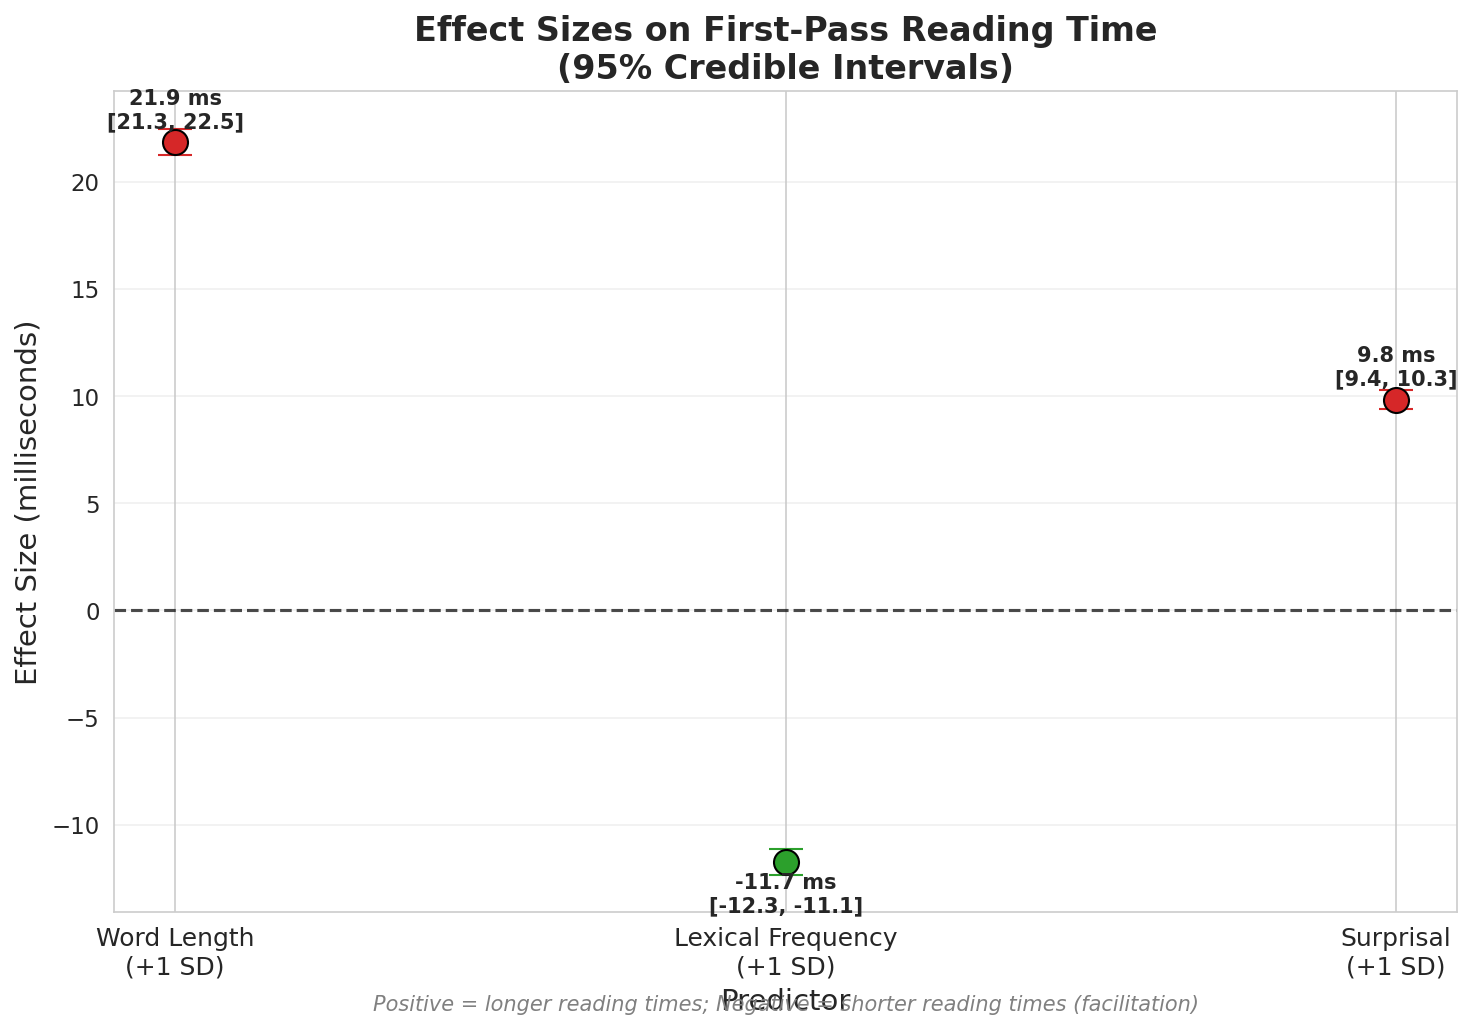


Posterior samples saved to model_fits/baseline_ms_FPRT.nc
Summary saved to model_fits/baseline_ms_FPRT_summary.csv
MS effects saved to model_fits/baseline_ms_FPRT_ms_effects.csv

Analysis complete!
Extended Bayesian Analysis for Eye-Tracking Reading Measures

Response variable: TFT
Analysis type: baseline
Iterations: 3000
Loading data from /kaggle/input/emtec-ds/reading_measures_corrected.csv...
  Loaded 387,005 observations
  Number of subjects: 107
  Number of items: 42
  Preprocessing complete.

PART 1: Baseline Analysis with Millisecond Effect Sizes

Fitting baseline model for TFT...
  Using 268,711 non-zero observations


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, Intercept, word_length, log_lex_freq, surprisal, last_in_line, 1|subject_id_sigma, 1|subject_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1315 seconds.
There were 1987 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Effect sizes in milliseconds (median RT = 256 ms):
------------------------------------------------------------
word_length    :   +29.2 ms  [  +28.4,   +29.9]
log_lex_freq   :   -19.1 ms  [  -19.8,   -18.3]
surprisal      :   +18.8 ms  [  +18.1,   +19.4]
last_in_line   :    +2.5 ms  [   +1.0,    +4.2]
Plot saved to plots/baseline_TFT_ms_effects.png


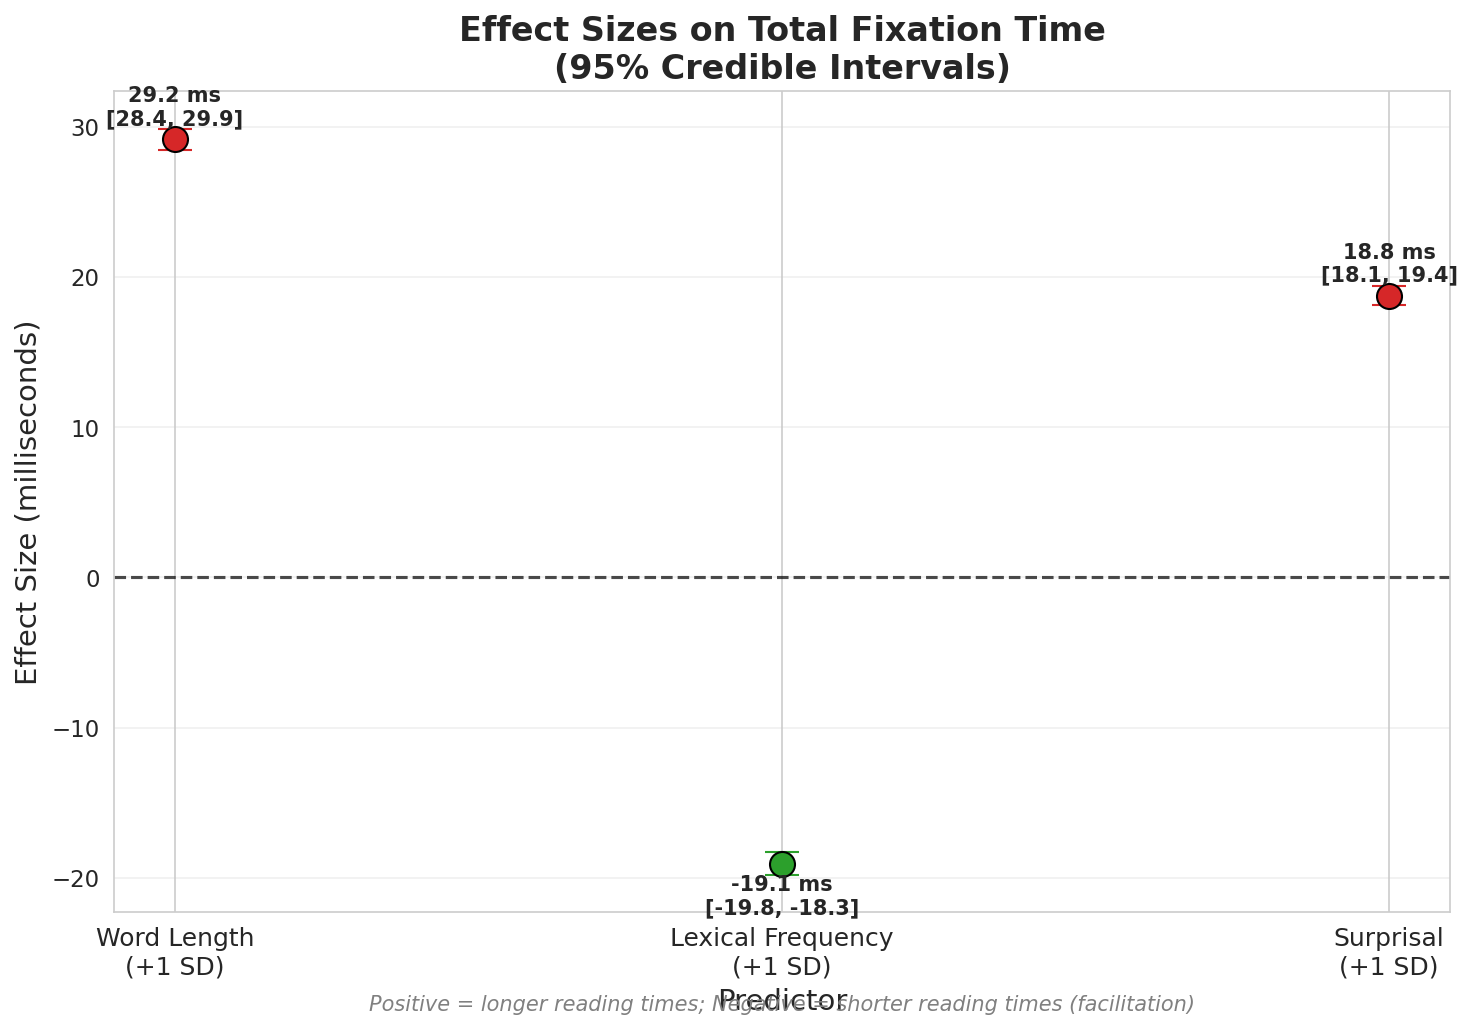


Posterior samples saved to model_fits/baseline_ms_TFT.nc
Summary saved to model_fits/baseline_ms_TFT_summary.csv
MS effects saved to model_fits/baseline_ms_TFT_ms_effects.csv

Analysis complete!
Extended Bayesian Analysis for Eye-Tracking Reading Measures

Response variable: FPRT
Analysis type: surprisal
Iterations: 3000
Loading data from /kaggle/input/emtec-ds/reading_measures_corrected.csv...
  Loaded 387,005 observations
  Number of subjects: 107
  Number of items: 42
  Preprocessing complete.

PART 2: Multi-LLM Surprisal Comparison

Fitting multi-LLM surprisal model for FPRT...
  Available surprisal columns: ['surprisal_gpt2', 'surprisal_opt-1.3b', 'surprisal_mistral-base', 'surprisal_phi2', 'surprisal_llama2-13b', 'surprisal_pythia-12b']
  Formula: FPRT ~ (1 | subject_id) + surprisal_gpt2 + surprisal_opt-1.3b + surprisal_mistral-base + surprisal_phi2 + surprisal_llama2-13b + surprisal_pythia-12b
  Using 232,819 non-zero observations


KeyError: 'surprisal_opt'

In [3]:
# Run Baseline for FPRT
main(analysis="baseline", response="FPRT", iterations=3000)

# Run Baseline for TFT
main(analysis="baseline", response="TFT", iterations=3000)

Extended Bayesian Analysis for Eye-Tracking Reading Measures

Response variable: FPRT
Analysis type: surprisal
Iterations: 3000
Loading data from /kaggle/input/emtec-ds/reading_measures_corrected.csv...
  Loaded 387,005 observations
  Number of subjects: 107
  Number of items: 42
  Renamed surprisal_opt-1.3b -> surprisal_opt_1_3b
  Renamed surprisal_mistral-base -> surprisal_mistral_base
  Renamed surprisal_llama2-13b -> surprisal_llama2_13b
  Renamed surprisal_pythia-12b -> surprisal_pythia_12b
  Preprocessing complete.

PART 2: Multi-LLM Surprisal Comparison

Fitting multi-LLM surprisal model for FPRT...
  Available surprisal columns: ['surprisal_gpt2', 'surprisal_opt_1_3b', 'surprisal_mistral_base', 'surprisal_phi2', 'surprisal_llama2_13b', 'surprisal_pythia_12b']
  Formula: FPRT ~ (1 | subject_id) + surprisal_gpt2 + surprisal_opt_1_3b + surprisal_mistral_base + surprisal_phi2 + surprisal_llama2_13b + surprisal_pythia_12b
  Using 232,819 non-zero observations


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, Intercept, surprisal_gpt2, surprisal_opt_1_3b, surprisal_mistral_base, surprisal_phi2, surprisal_llama2_13b, surprisal_pythia_12b, 1|subject_id_sigma, 1|subject_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1586 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Surprisal effects in milliseconds (median RT = 228 ms):
----------------------------------------------------------------------
GPT-2          :   +24.6 ms  [  +23.8,   +25.5]
OPT-1.3B       :    +0.3 ms  [   -0.9,    +1.6]
Mistral        :    -4.1 ms  [   -5.8,    -2.3]
Phi-2          :    -1.8 ms  [   -2.6,    -1.0]
LLaMA2-13B     :    -2.8 ms  [   -4.4,    -1.0]
Pythia-12B     :    +4.4 ms  [   +3.4,    +5.4]
Comparison plot saved to plots/surprisal_comparison_FPRT.png


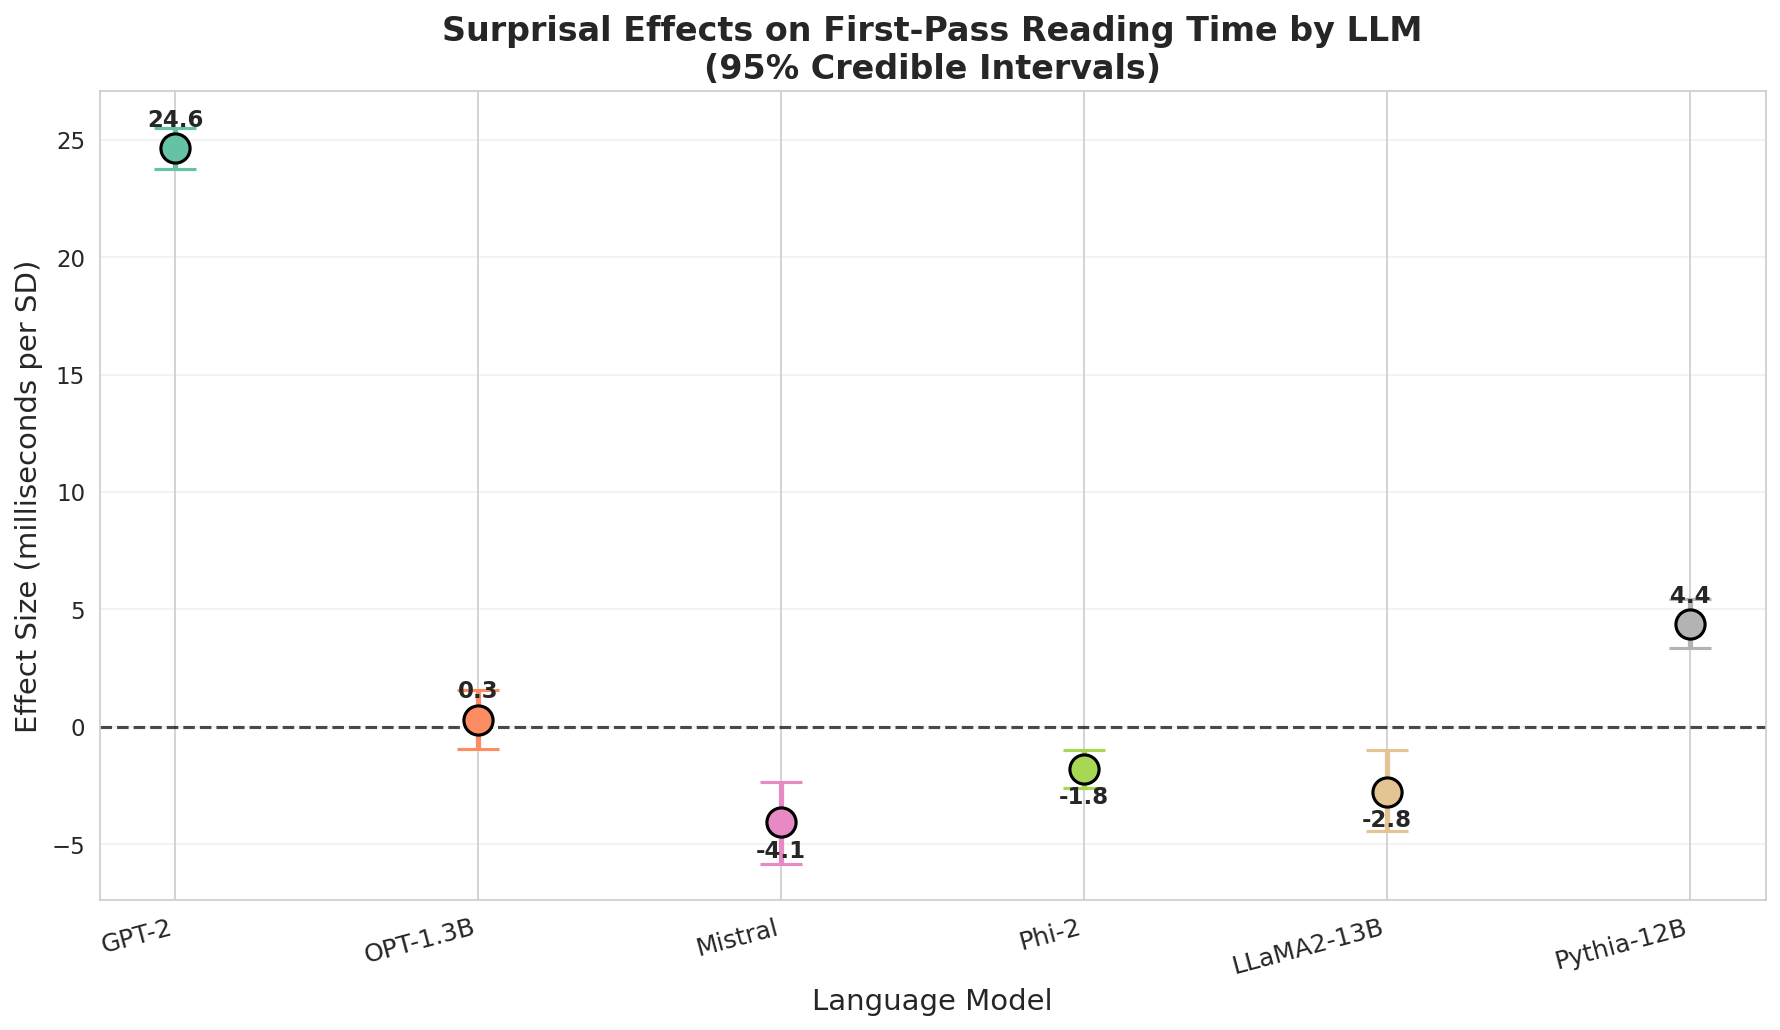

Multi-LLM plot saved to plots/surprisal_effects_all_llms_FPRT.png


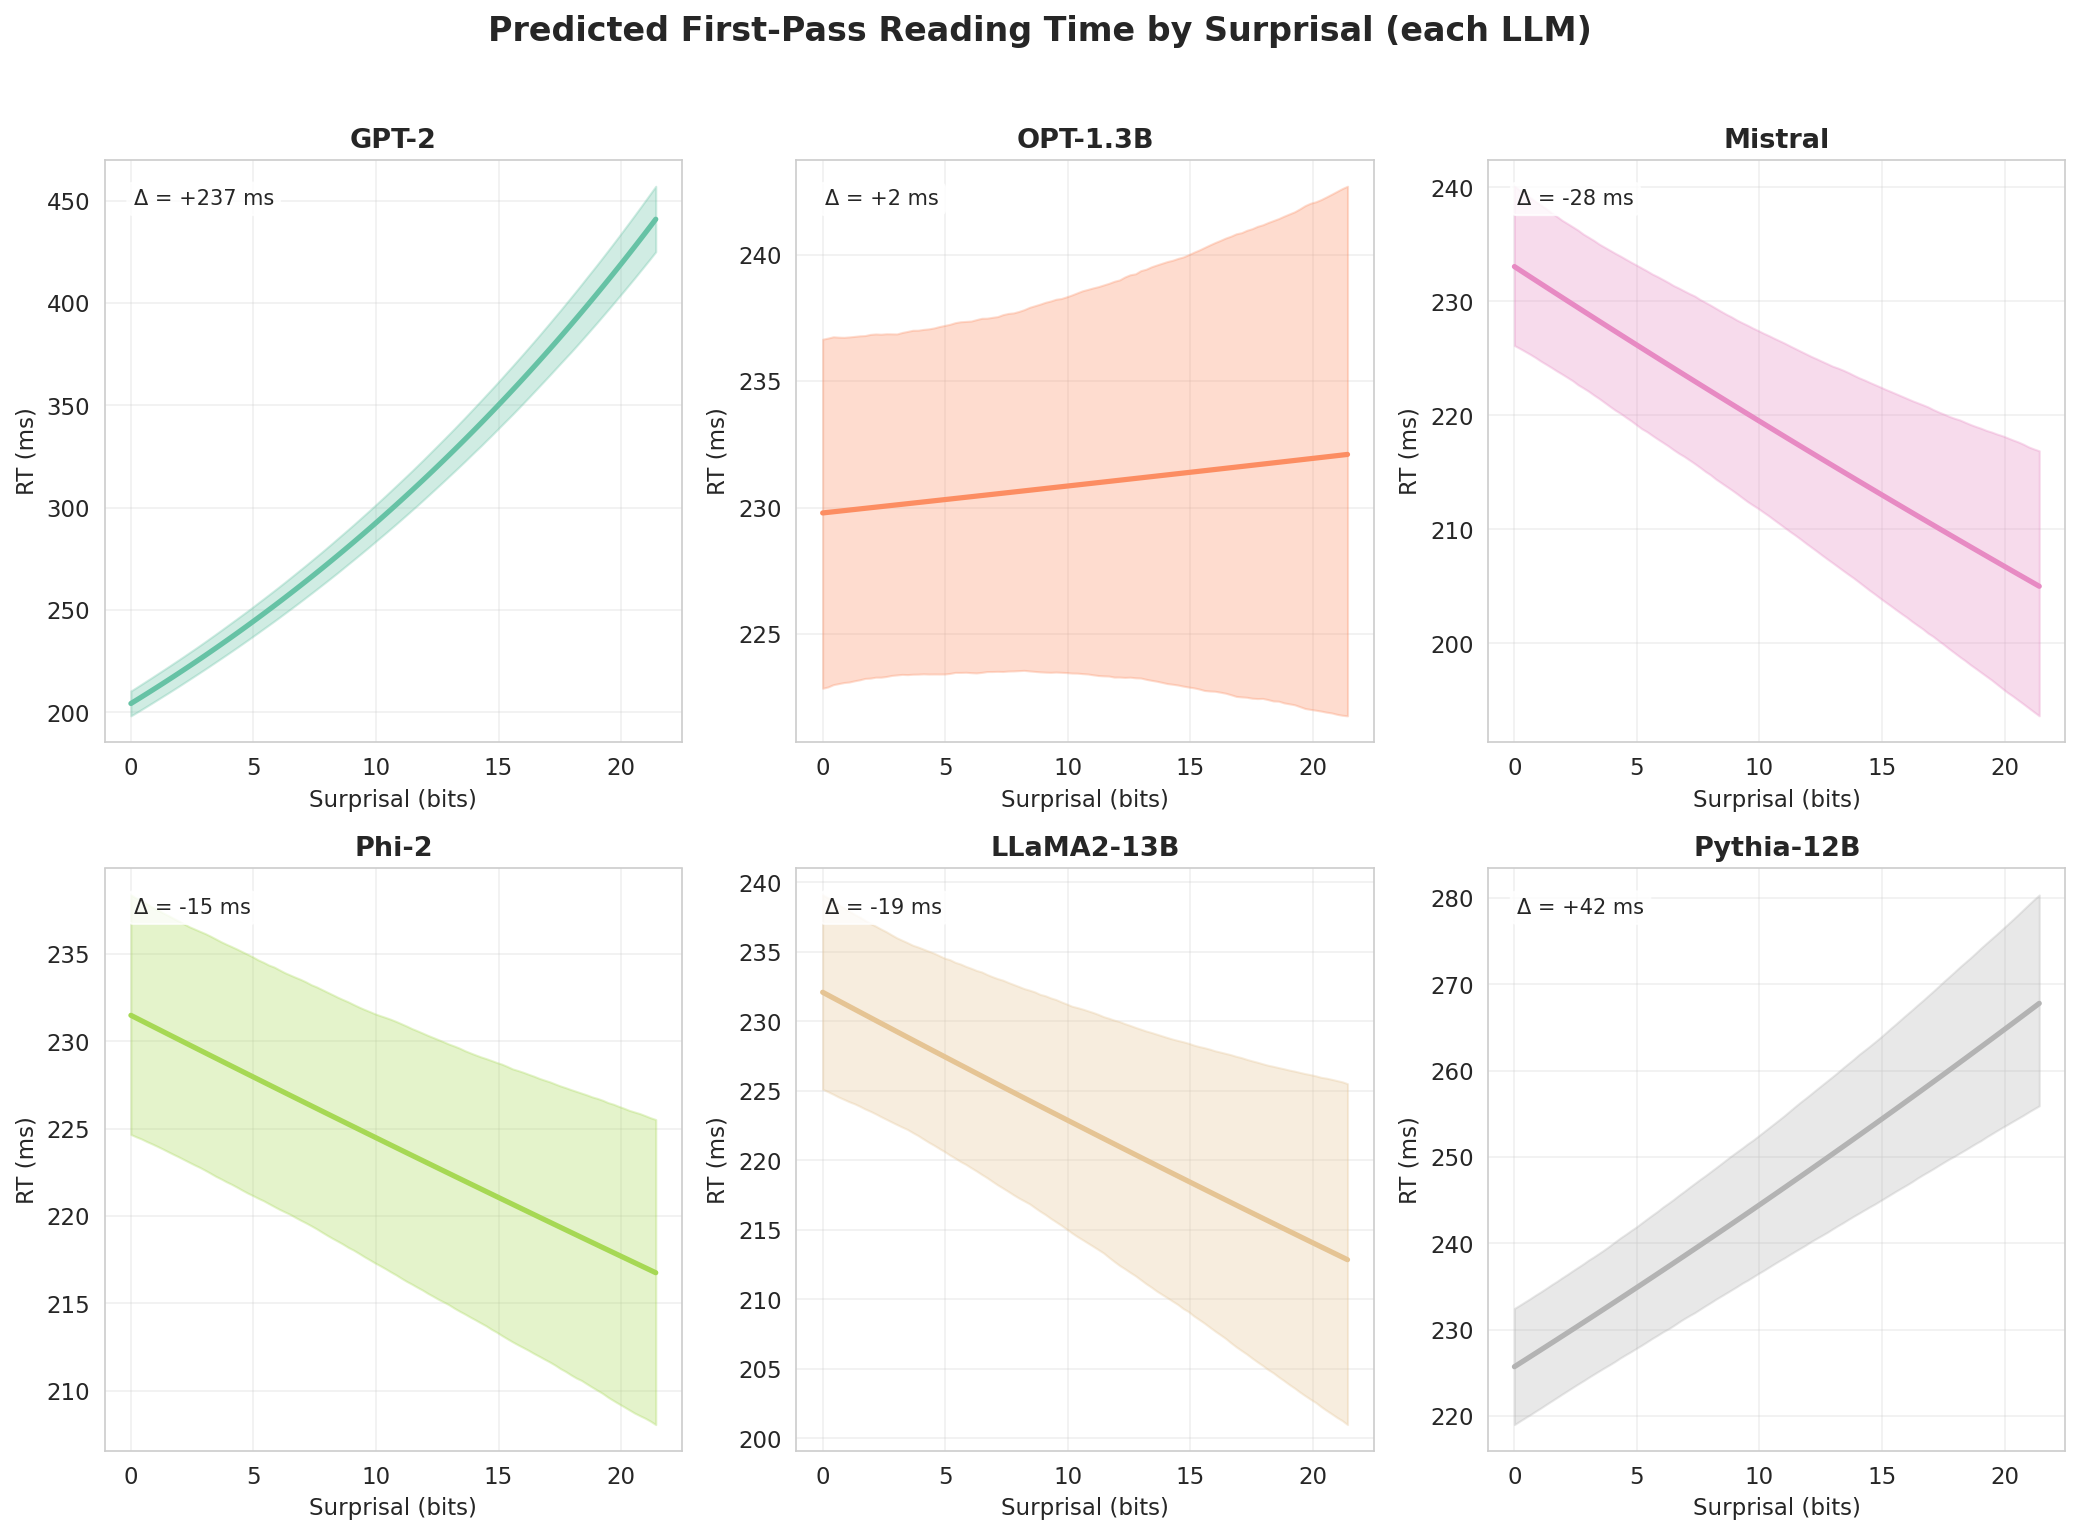

Overlay plot saved to plots/surprisal_overlay_FPRT.png


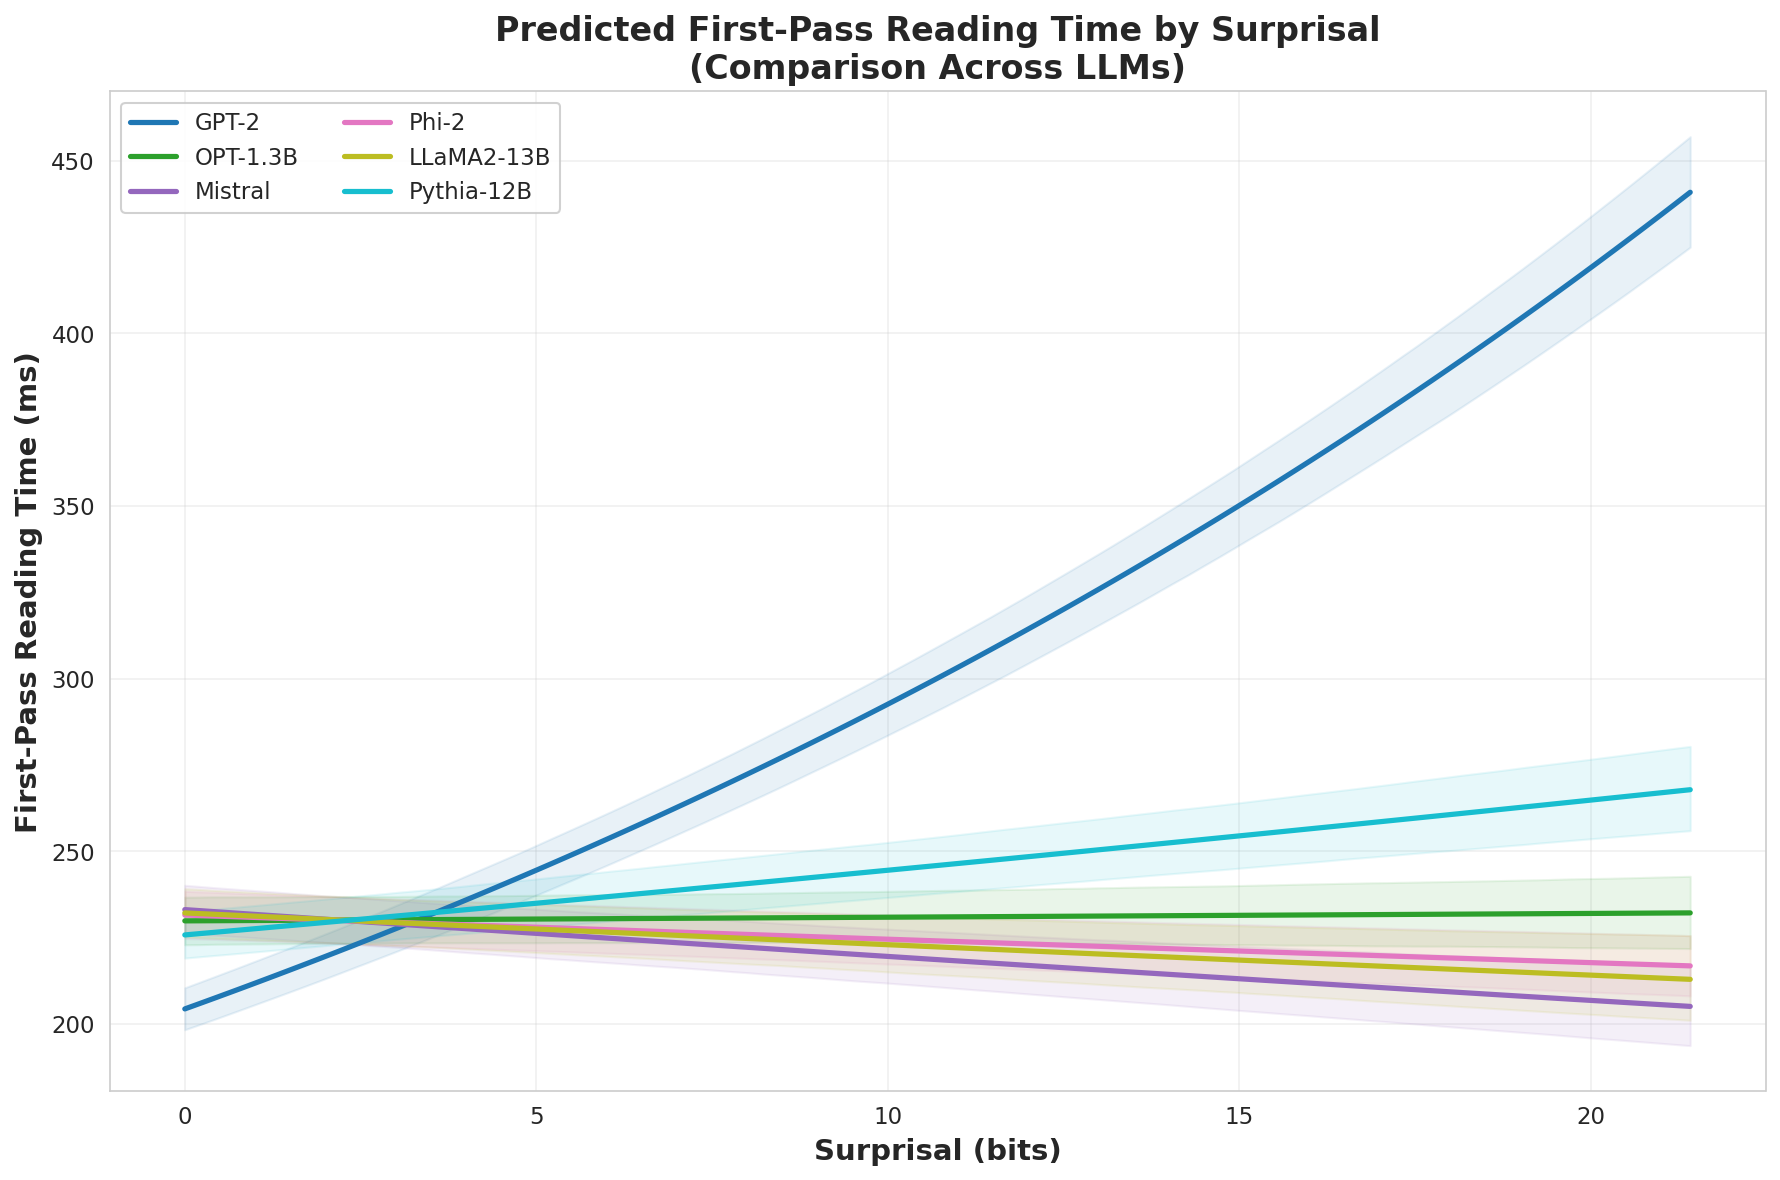


Posterior samples saved to model_fits/surprisal_multi_llm_FPRT.nc
Summary saved to model_fits/surprisal_multi_llm_FPRT_summary.csv
MS effects saved to model_fits/surprisal_multi_llm_FPRT_ms_effects.csv

Analysis complete!
Extended Bayesian Analysis for Eye-Tracking Reading Measures

Response variable: TFT
Analysis type: surprisal
Iterations: 3000
Loading data from /kaggle/input/emtec-ds/reading_measures_corrected.csv...
  Loaded 387,005 observations
  Number of subjects: 107
  Number of items: 42
  Renamed surprisal_opt-1.3b -> surprisal_opt_1_3b
  Renamed surprisal_mistral-base -> surprisal_mistral_base
  Renamed surprisal_llama2-13b -> surprisal_llama2_13b
  Renamed surprisal_pythia-12b -> surprisal_pythia_12b
  Preprocessing complete.

PART 2: Multi-LLM Surprisal Comparison

Fitting multi-LLM surprisal model for TFT...
  Available surprisal columns: ['surprisal_gpt2', 'surprisal_opt_1_3b', 'surprisal_mistral_base', 'surprisal_phi2', 'surprisal_llama2_13b', 'surprisal_pythia_12b']
 

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, Intercept, surprisal_gpt2, surprisal_opt_1_3b, surprisal_mistral_base, surprisal_phi2, surprisal_llama2_13b, surprisal_pythia_12b, 1|subject_id_sigma, 1|subject_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1967 seconds.
There were 2000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details



Surprisal effects in milliseconds (median RT = 256 ms):
----------------------------------------------------------------------
GPT-2          :   +38.2 ms  [  +37.0,   +39.4]
OPT-1.3B       :    +0.4 ms  [   -1.1,    +2.0]
Mistral        :    -2.8 ms  [   -4.8,    -0.8]
Phi-2          :    +1.5 ms  [   +0.5,    +2.6]
LLaMA2-13B     :    -9.0 ms  [  -11.0,    -7.0]
Pythia-12B     :    +8.1 ms  [   +6.8,    +9.4]
Comparison plot saved to plots/surprisal_comparison_TFT.png


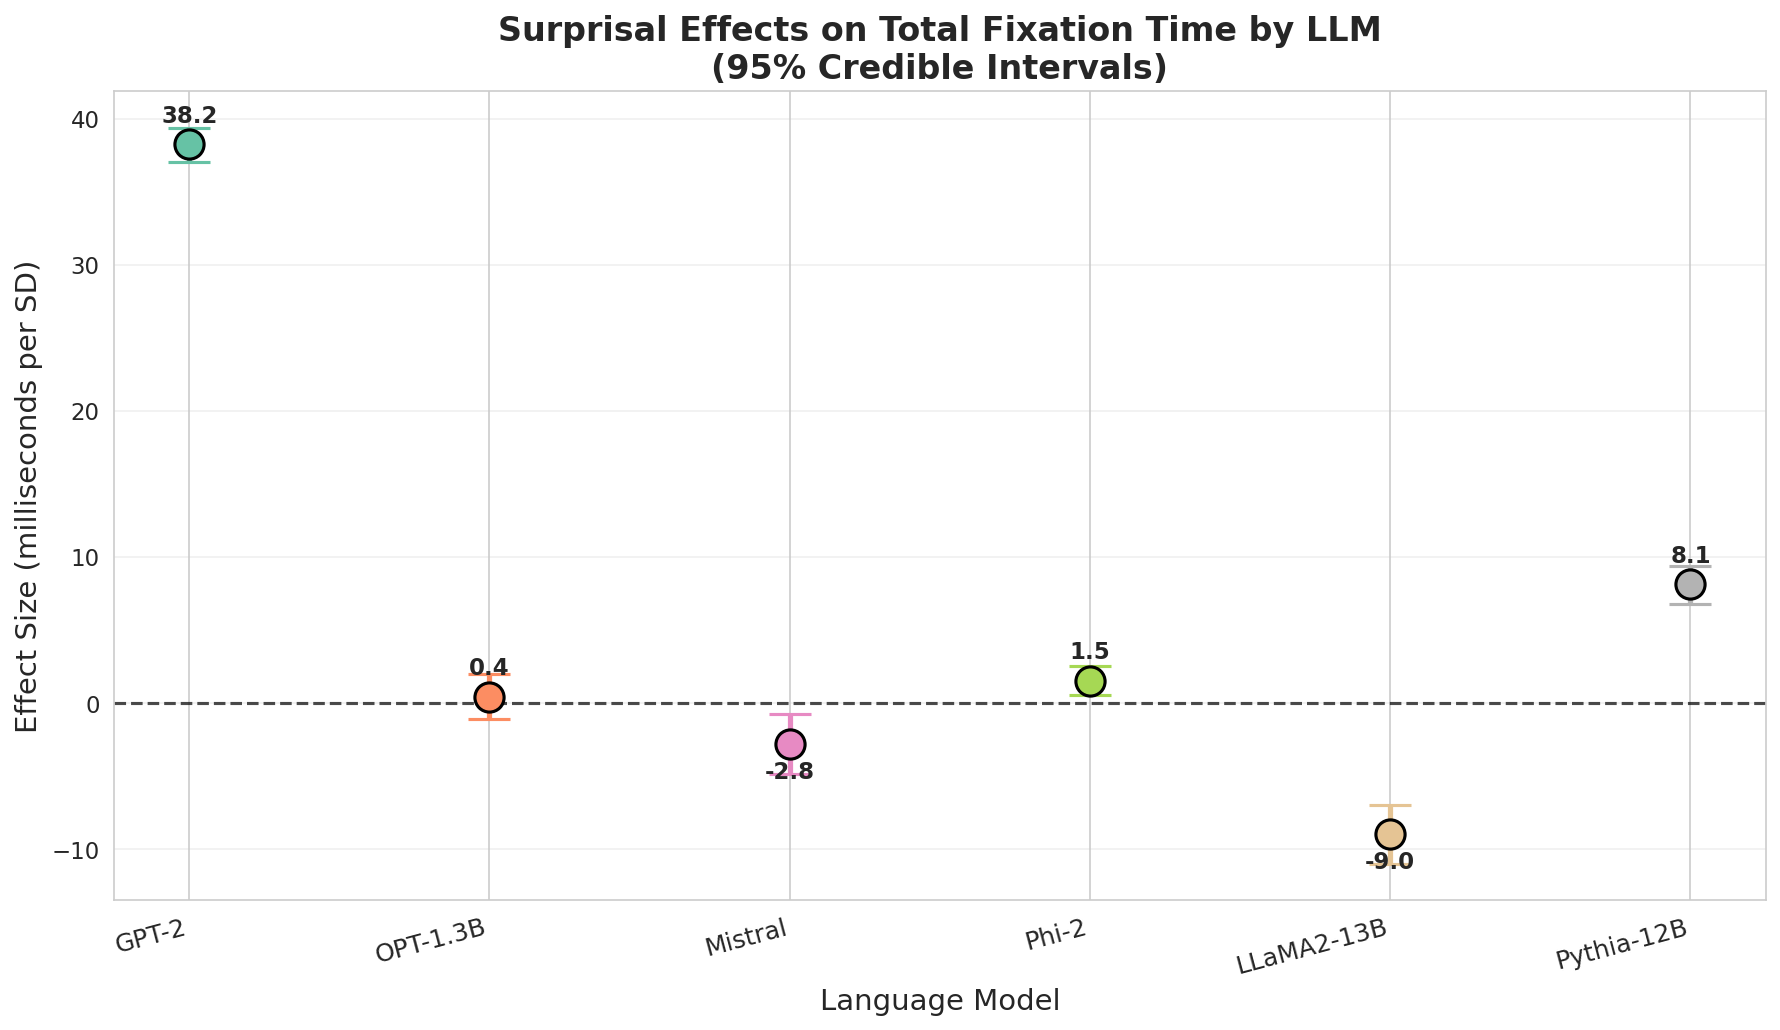

Multi-LLM plot saved to plots/surprisal_effects_all_llms_TFT.png


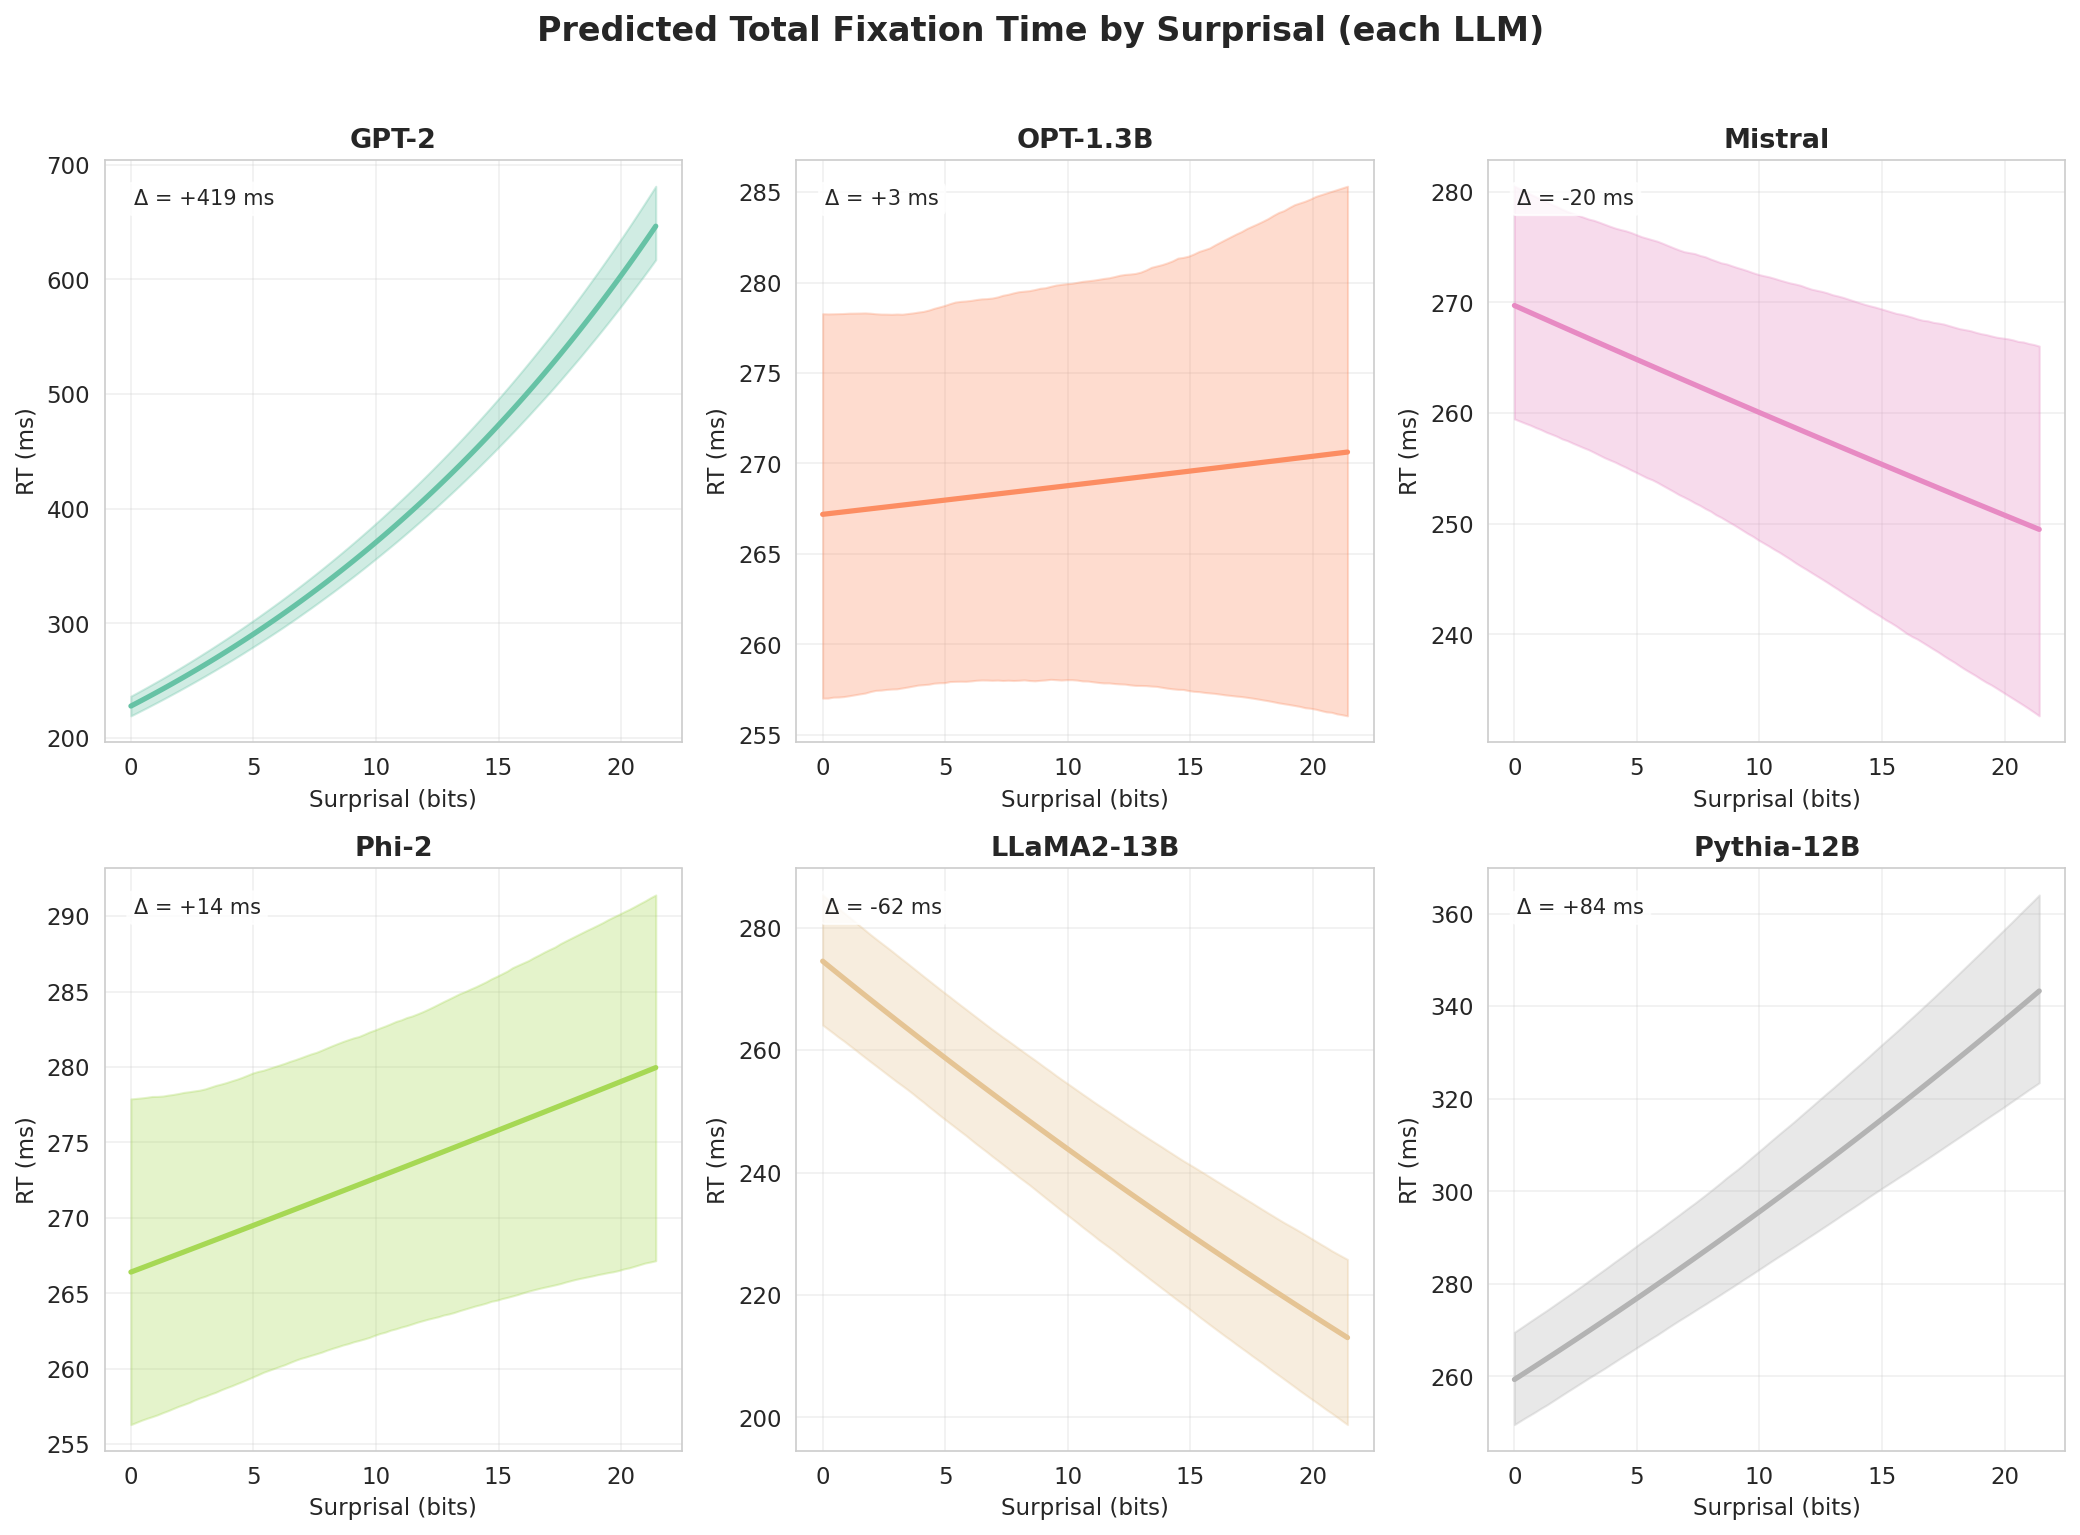

Overlay plot saved to plots/surprisal_overlay_TFT.png


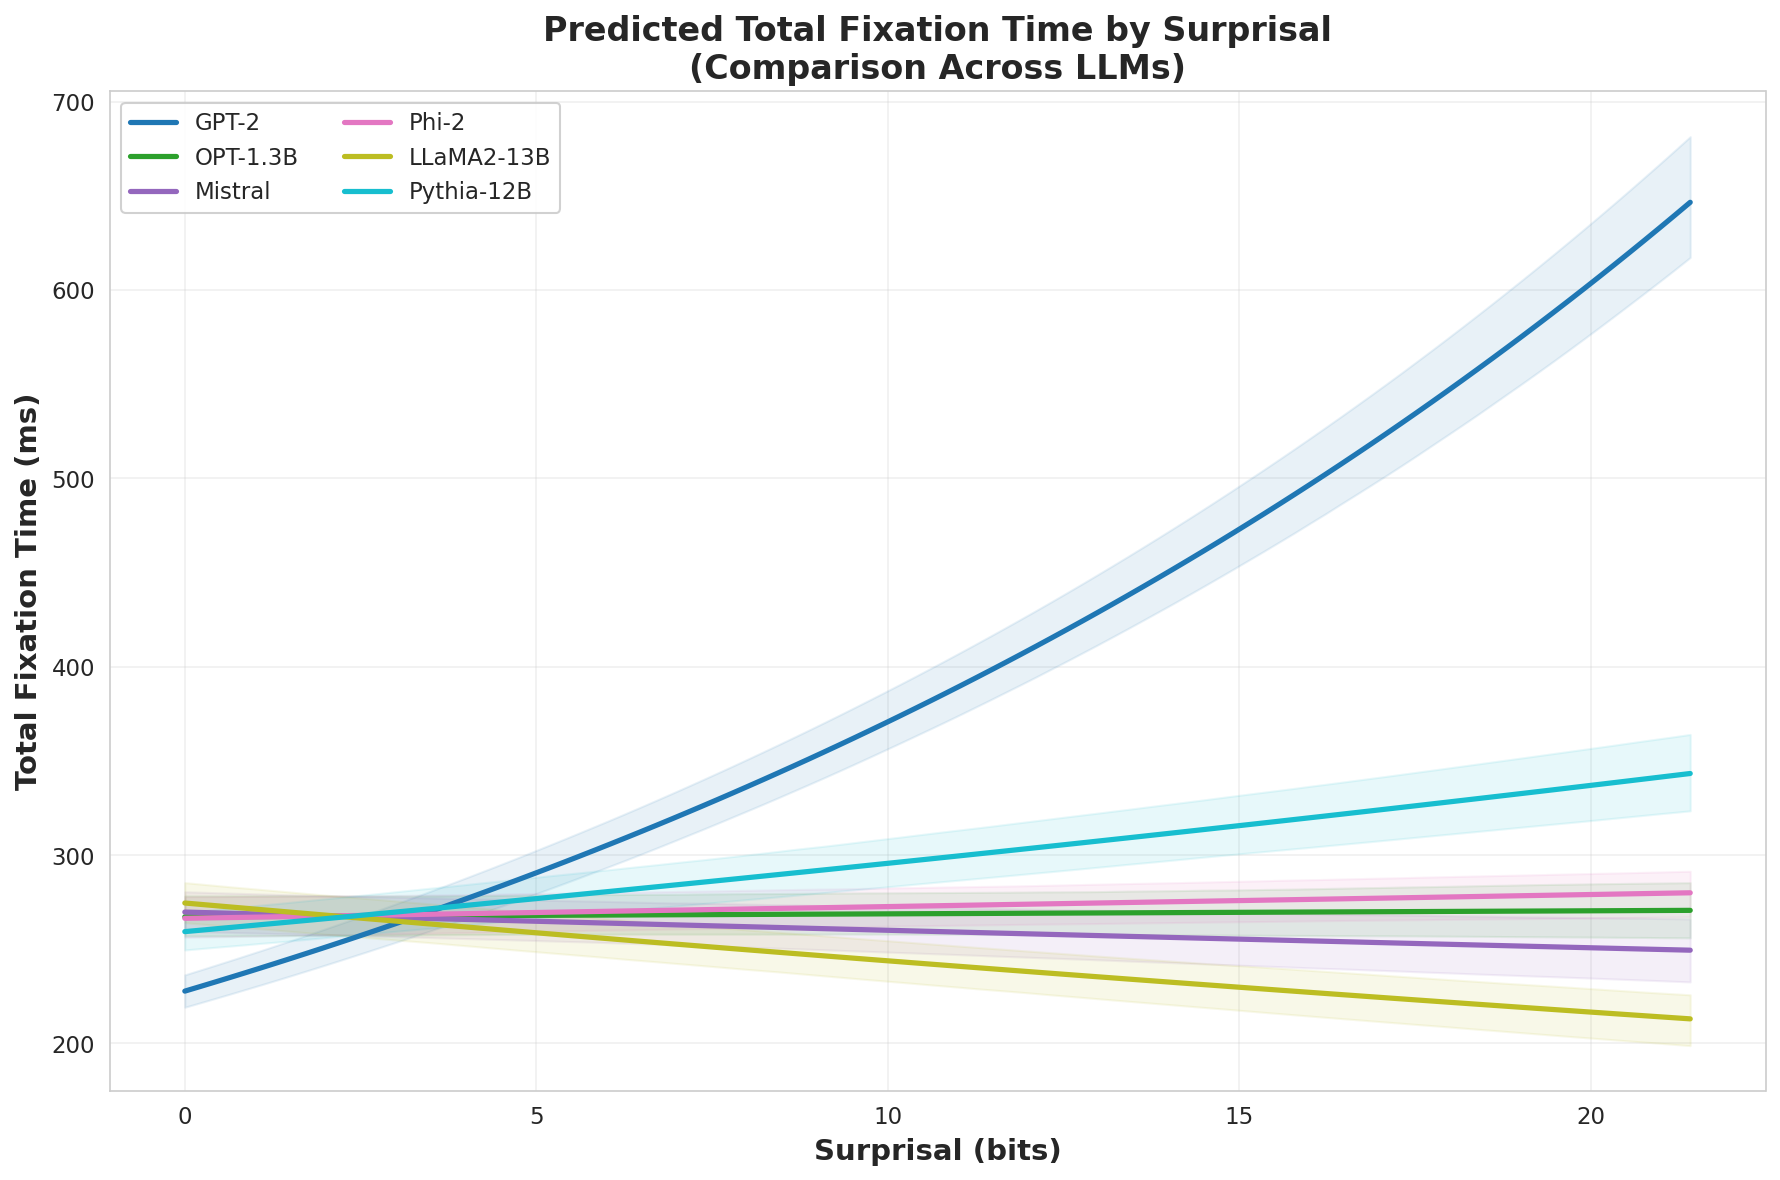


Posterior samples saved to model_fits/surprisal_multi_llm_TFT.nc
Summary saved to model_fits/surprisal_multi_llm_TFT_summary.csv
MS effects saved to model_fits/surprisal_multi_llm_TFT_ms_effects.csv

Analysis complete!


In [7]:
# Run Surprisal for FPRT
main(analysis="surprisal", response="FPRT", iterations=3000)

# Run Surprisal for TFT
main(analysis="surprisal", response="TFT", iterations=3000)